In [1]:
# library
import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing

from numpy.random import seed
from tensorflow import set_random_seed

from keras.layers import Input, Dropout
from keras.layers.core import Dense 
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json

Using TensorFlow backend.


### Load data

In [2]:
df = pd.read_csv('merged_dataset_BearingTest_2.csv',index_col=[0])
df.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 984 entries, 2004-02-12 10:32:39 to 2004-02-19 06:22:39
Data columns (total 4 columns):
Bearing 1    984 non-null float64
Bearing 2    984 non-null float64
Bearing 3    984 non-null float64
Bearing 4    984 non-null float64
dtypes: float64(4)
memory usage: 38.4+ KB


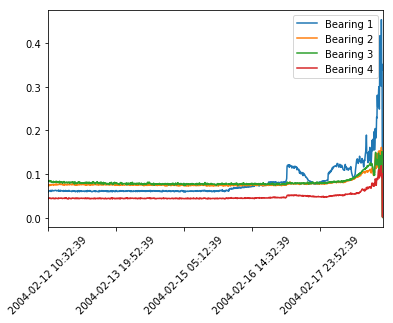

In [4]:
df.plot()
plt.xticks(rotation=45)
plt.show()

### Split data

In [5]:
dataset_train = df['2004-02-12 11:02:39':'2004-02-13 23:52:39']
dataset_test = df['2004-02-13 23:52:39':]

dataset_train.shape, dataset_test.shape

((222, 4), (760, 4))

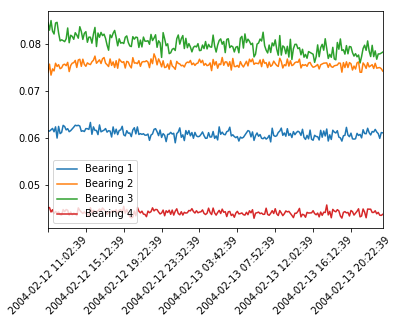

In [6]:
dataset_train.plot()
plt.xticks(rotation=45)
plt.show()

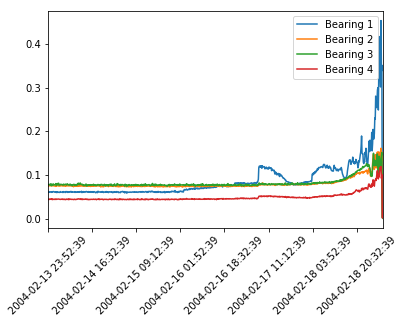

In [7]:
dataset_test.plot()
plt.xticks(rotation=45)
plt.show()

### Normalization

In [0]:
scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(dataset_train), 
                              columns=dataset_train.columns, 
                              index=dataset_train.index)

In [0]:
# Random shuffle training data
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(dataset_test), 
                             columns=dataset_test.columns, 
                             index=dataset_test.index)

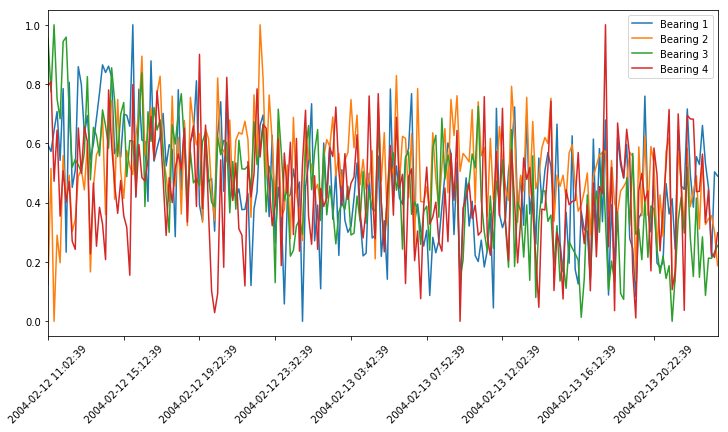

In [10]:
X_train.plot(figsize = (12,6))
plt.xticks(rotation=45)
plt.show()

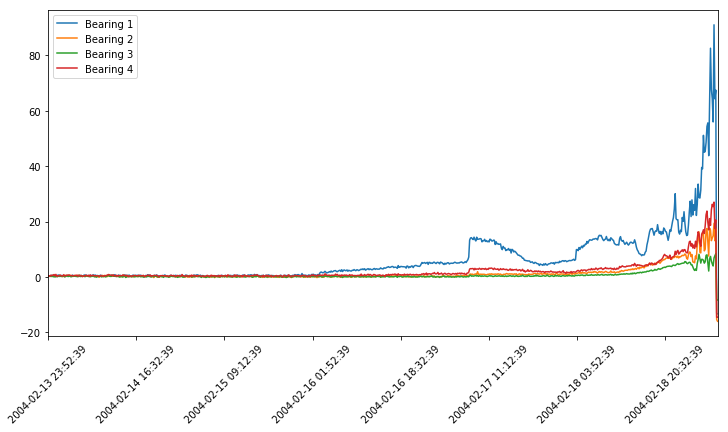

In [11]:
X_test.plot(figsize = (12,6))
plt.xticks(rotation=45)
plt.show()

### Build a model
The basic idea here is to use an autoencoder neural network to “compress” the sensor readings to a low dimensional representation, which captures the correlations and interactions between the various variables. (Essentially the same principle as the PCA model, but here we also allow for non-linearities among the input variables).

In [12]:
seed(10)
set_random_seed(10)
act_func = 'elu'

# Input layer:
model=Sequential()

# First hidden layer, connected to input vector X. 
model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_shape=(X_train.shape[1],)
               )
         )

# 2nd layer
model.add(Dense(2,activation=act_func,
                kernel_initializer='glorot_uniform'))

# 3rd layer
model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=100
BATCH_SIZE=10

W0718 18:55:55.198091 140505606653824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0718 18:55:55.200540 140505606653824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0718 18:55:55.203369 140505606653824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0718 18:55:55.267823 140505606653824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                50        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 22        
_________________________________________________________________
dense_3 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 44        
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


There were  3 layer neural networks:
- First layer has 10 nodes
- Middle layer has 2 nodes
- Third layer has 10 nodes. 

We use the mean square error as loss function, and train the model using the “Adam” optimizer.

In [14]:
# fit model
# keep track of the accuracy during training, we use 5% of the training data for validation after each epoch (validation_split = 0.05)
history=model.fit(np.array(X_train),np.array(X_train),
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.05,
                  verbose = 1)

W0718 18:55:55.433410 140505606653824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0718 18:55:55.550823 140505606653824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 210 samples, validate on 12 samples
Epoch 1/100
210/210 [==============================] - 0s 1ms/step - loss: 0.2798 - val_loss: 0.1874
Epoch 2/100
210/210 [==============================] - 0s 126us/step - loss: 0.1488 - val_loss: 0.0884
Epoch 3/100
210/210 [==============================] - 0s 131us/step - loss: 0.0793 - val_loss: 0.0473
Epoch 4/100
210/210 [==============================] - 0s 147us/step - loss: 0.0485 - val_loss: 0.0347
Epoch 5/100
210/210 [==============================] - 0s 126us/step - loss: 0.0375 - val_loss: 0.0320
Epoch 6/100
210/210 [==============================] - 0s 151us/step - loss: 0.0344 - val_loss: 0.0339
Epoch 7/100
210/210 [==============================] - 0s 128us/step - loss: 0.0334 - val_loss: 0.0341
Epoch 8/100
210/210 [==============================] - 0s 130us/step - loss: 0.0329 - val_loss: 0.0332
Epoch 9/100
210/210 [==============================] - 0s 143us/step - loss: 0.0323 - val_loss: 0.0338
Epoch 10/100
210/210 [========

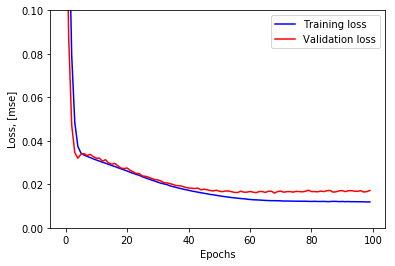

In [15]:
# Visualize training/validation loss:
plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.ylim([0,.1])
plt.show()

### Results

**Distribution of loss function in the training set:**

By plotting the distribution of the calculated loss in the training set, one can use this to identify a suitable threshold value for identifying an anomaly. In doing this, one can make sure that this threshold is set above the “noise level”, and that any flagged anomalies should be statistically significant above the noise background.

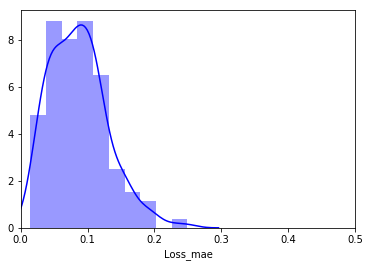

In [16]:
X_pred = model.predict(np.array(X_train))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_train.columns)
X_pred.index = X_train.index

scored = pd.DataFrame(index=X_train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)
plt.figure()
sns.distplot(scored['Loss_mae'],
             bins = 10, 
             kde= True,
            color = 'blue');
plt.xlim([0.0,.5])
plt.show()

**Let us try a threshold of 0.3 for flagging an anomaly**

In [17]:
X_pred = model.predict(np.array(X_test))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_test.columns)
X_pred.index = X_test.index

scored = pd.DataFrame(index=X_test.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_test), axis = 1)
scored['Threshold'] = 0.3
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head(10)

,Loss_mae,Threshold,Anomaly
2004-02-13 23:52:39,0.132934,0.3,False
2004-02-14 00:02:39,0.117413,0.3,False
2004-02-14 00:12:39,0.034935,0.3,False
2004-02-14 00:22:39,0.143956,0.3,False
2004-02-14 00:32:39,0.071225,0.3,False
2004-02-14 00:42:39,0.087286,0.3,False
2004-02-14 00:52:39,0.177635,0.3,False
2004-02-14 01:02:39,0.200752,0.3,False
2004-02-14 01:12:39,0.083314,0.3,False
2004-02-14 01:22:39,0.204871,0.3,False


In [18]:
scored.tail(10)

,Loss_mae,Threshold,Anomaly
2004-02-19 04:52:39,30.686242,0.3,True
2004-02-19 05:02:39,36.961929,0.3,True
2004-02-19 05:12:39,30.058868,0.3,True
2004-02-19 05:22:39,30.115307,0.3,True
2004-02-19 05:32:39,27.895116,0.3,True
2004-02-19 05:42:39,42.266267,0.3,True
2004-02-19 05:52:39,27.670077,0.3,True
2004-02-19 06:02:39,31.541047,0.3,True
2004-02-19 06:12:39,3.435355,0.3,True
2004-02-19 06:22:39,3.439168,0.3,True


In [0]:
# calculate the same metrics also for the training set, and merge all data in a single dataframe:
X_pred_train = model.predict(np.array(X_train))
X_pred_train = pd.DataFrame(X_pred_train, 
                      columns=X_train.columns)
X_pred_train.index = X_train.index

scored_train = pd.DataFrame(index=X_train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
scored_train['Threshold'] = 0.3
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

In [20]:
scored_train.Anomaly.value_counts()

False    222
Name: Anomaly, dtype: int64

In [21]:
scored.Anomaly.value_counts()

False    522
True     460
Name: Anomaly, dtype: int64

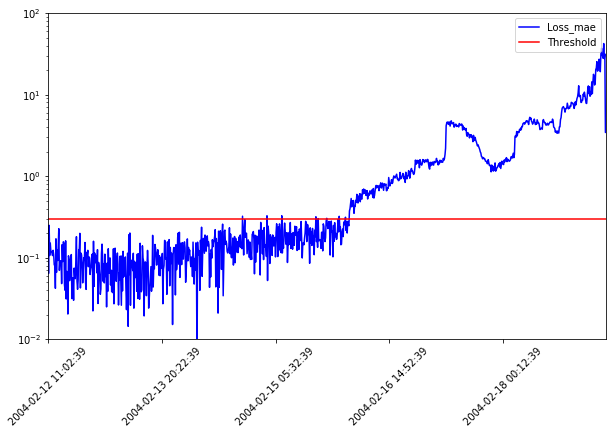

In [22]:
# the model output in the time leading up to the bearing failure
scored.plot(logy=True,  figsize = (10,6), ylim = [1e-2,1e2], color = ['blue','red'])
plt.xticks(rotation=45)
plt.show()